In [1]:
import pandas as pd
import numpy as np
from MCMC import run_mcmc_with_gibbs
import os

In [2]:
directory = '../out/'
dataframes = []  # List to hold dataframes
for filename in os.listdir(directory):
    if filename.endswith('.parquet'):  # Ensures only parquet files are read
        filepath = os.path.join(directory, filename)
        df = pd.read_parquet(filepath)  # Read parquet file to a pandas df
        dataframes.append(df)  # Append the df to the list
df = pd.concat(dataframes, ignore_index=True)

df.prob = df.prob.astype('float32')

In [3]:
pivot_df = df.pivot_table(columns='species', index='molecule', values='prob')
del df

In [4]:
df_agg_train = pd.read_csv("../data/lotus_agg_train.csv.gz", index_col=0)
df_agg_test = pd.read_csv("../data/lotus_agg_test.csv.gz", index_col=0)
df_agg = pd.concat([df_agg_train, df_agg_test])

In [5]:
df_agg = df_agg[df_agg.organism_name.isin(pivot_df.columns)]

In [6]:
lotus_n_papers = pd.pivot_table(df_agg,
                                values='reference_wikidata',
                                columns='organism_name',
                                index='structure_smiles_2D', fill_value=0).astype('uint8')

In [7]:
pivot_df = pivot_df[pivot_df.index.isin(lotus_n_papers.index)]
pivot_df.drop(columns='Arnica amplexicaulis', inplace=True)

In [8]:
pivot_df

species,Aepyceros melampus,Alternaria jesenskae,Aplidium uouo,Arabidopsis thaliana,Asterospicularia laurae,Bacillus subtilis,Balansia strangulans,Berkleasmium nigroapicale,Betula maximowicziana,Bipolaris eleusines,...,Sarcodon leucopus,Soroseris hookeriana,Streptomyces aureofaciens,Streptomyces cyaneofuscatus,Streptomyces filamentosus,Sulfolobus shibatae,Thermoplasma acidophilum,Thorecta reticulata,Vismia baccifera,Xylobolus frustulatus
molecule,,,,,,,,,,,,,,,,,,,,,
BrCCBr,0.649736,0.024518,0.234415,0.933224,0.214280,0.768582,0.016286,0.036428,0.443683,0.092393,...,0.063031,0.008528,0.667078,0.477832,0.756213,0.034029,0.667653,0.072682,0.266468,0.138533
C#CC#CC#CC#CC=CC=CC(O)CCCCC(=O)O,0.328519,0.002646,0.001289,0.578789,0.091989,0.503281,0.000247,0.002428,0.014602,0.016561,...,0.001083,0.000754,0.745298,0.759222,0.839227,0.002080,0.065082,0.001273,0.001001,0.006786
C#CCC(N)C(=O)O,0.717814,0.105138,0.079118,0.933914,0.327850,0.871273,0.031756,0.110182,0.630513,0.283944,...,0.147795,0.406515,0.824965,0.847676,0.927065,0.039015,0.601694,0.043220,0.553870,0.272397
C#N,0.769380,0.139915,0.475483,0.987917,0.357480,0.524086,0.363651,0.324169,0.660137,0.449652,...,0.119654,0.637630,0.733808,0.618014,0.734630,0.007554,0.456963,0.116903,0.875465,0.408041
C1=Cc2cc3ccc(cc4nc(cc5ccc(cc1n2)[nH]5)C=C4)[nH]3,0.763553,0.058577,0.083051,0.982904,0.134009,0.761787,0.038326,0.118171,0.371837,0.164196,...,0.076758,0.036511,0.797838,0.839468,0.797429,0.021576,0.784635,0.027132,0.194575,0.100456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1ccc2c(c1)Nc1ccccc1N2,0.356226,0.002498,0.006333,0.309396,0.121019,0.501623,0.002364,0.001870,0.005759,0.009537,...,0.000614,0.000615,0.697702,0.805787,0.810666,0.000492,0.085264,0.004159,0.000586,0.001758
c1ccc2c(c1)[nH]c1cnccc12,0.614740,0.322838,0.156730,0.865384,0.535288,0.613909,0.585751,0.166649,0.544033,0.718919,...,0.082495,0.353500,0.478459,0.575909,0.697875,0.016741,0.377206,0.259644,0.501725,0.340554
c1ccncc1,0.644477,0.109947,0.062889,0.937383,0.290649,0.517313,0.124534,0.254992,0.834993,0.434781,...,0.101844,0.464376,0.523274,0.322645,0.547942,0.014534,0.314960,0.090823,0.767256,0.318354


In [9]:
lotus_n_papers

organism_name,Aepyceros melampus,Alternaria jesenskae,Aplidium uouo,Arabidopsis thaliana,Asterospicularia laurae,Bacillus subtilis,Balansia strangulans,Berkleasmium nigroapicale,Betula maximowicziana,Bipolaris eleusines,...,Sarcodon leucopus,Soroseris hookeriana,Streptomyces aureofaciens,Streptomyces cyaneofuscatus,Streptomyces filamentosus,Sulfolobus shibatae,Thermoplasma acidophilum,Thorecta reticulata,Vismia baccifera,Xylobolus frustulatus
structure_smiles_2D,,,,,,,,,,,,,,,,,,,,,
BrCCBr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C#CC#CC#CC#CC=CC=CC(O)CCCCC(=O)O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C#CCC(N)C(=O)O,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1=Cc2cc3ccc(cc4nc(cc5ccc(cc1n2)[nH]5)C=C4)[nH]3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1ccc2c(c1)Nc1ccccc1N2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c1ccc2c(c1)[nH]c1cnccc12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c1ccncc1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
n_iter = 20000
x_init = np.zeros_like(lotus_n_papers)
gamma_init = 1
delta_init = 1

In [11]:
samples, x_samples, accept_gamma, accept_delta = run_mcmc_with_gibbs(
    lotus_n_papers.values, x_init, n_iter, gamma_init, delta_init, pivot_df.values)

Done : 0.0 % of total iterations
Done : 10.0 % of total iterations
Done : 20.0 % of total iterations
Done : 30.0 % of total iterations
Done : 40.0 % of total iterations
Done : 50.0 % of total iterations
Done : 60.0 % of total iterations
Done : 70.0 % of total iterations
Done : 80.0 % of total iterations
Done : 90.0 % of total iterations


In [12]:
burn_in = int(0.5 * n_iter)  # Remove the first 50% of the samples
post_burn_in_samples = samples[burn_in:]

# Extract the posterior mean estimates for gamma and delta
gamma_posterior_mean = np.mean(post_burn_in_samples[:, 0])
delta_posterior_mean = np.mean(post_burn_in_samples[:, 1])

print("Estimated gamma: ", gamma_posterior_mean)
print("Estimated delta: ", delta_posterior_mean)
print("rate accept gamma : ", accept_gamma)
print("rate accept delta : ", accept_delta)

Estimated gamma:  0.0009317326485321741
Estimated delta:  0.0002733208838016422
rate accept gamma :  0.304
rate accept delta :  0.266


<Axes: >

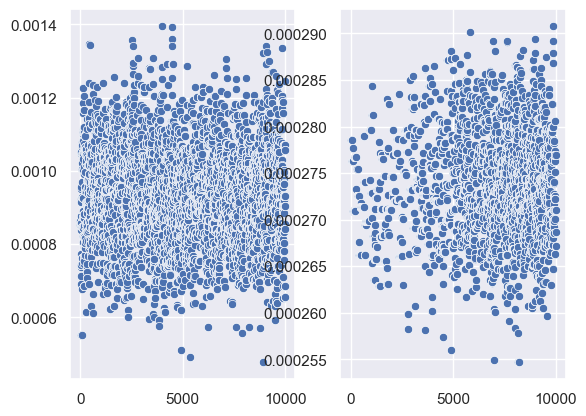

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(x=range(len(post_burn_in_samples)),
                y = post_burn_in_samples[:,0],
                ax=axs[0])
sns.scatterplot(x=range(len(post_burn_in_samples)),
                y=post_burn_in_samples[:,1],
                ax=axs[1])

In [46]:
out = pd.DataFrame(np.mean(x_samples[-3000:],axis=0, dtype='float32'),
                   index=lotus_n_papers.index,
                   columns=lotus_n_papers.columns,
                   dtype='float32')

In [47]:
pivot_df

species,Aepyceros melampus,Alternaria jesenskae,Aplidium uouo,Arabidopsis thaliana,Asterospicularia laurae,Bacillus subtilis,Balansia strangulans,Berkleasmium nigroapicale,Betula maximowicziana,Bipolaris eleusines,...,Sarcodon leucopus,Soroseris hookeriana,Streptomyces aureofaciens,Streptomyces cyaneofuscatus,Streptomyces filamentosus,Sulfolobus shibatae,Thermoplasma acidophilum,Thorecta reticulata,Vismia baccifera,Xylobolus frustulatus
molecule,,,,,,,,,,,,,,,,,,,,,
BrCCBr,0.649736,0.024518,0.234415,0.933224,0.214280,0.768582,0.016286,0.036428,0.443683,0.092393,...,0.063031,0.008528,0.667078,0.477832,0.756213,0.034029,0.667653,0.072682,0.266468,0.138533
C#CC#CC#CC#CC=CC=CC(O)CCCCC(=O)O,0.328519,0.002646,0.001289,0.578789,0.091989,0.503281,0.000247,0.002428,0.014602,0.016561,...,0.001083,0.000754,0.745298,0.759222,0.839227,0.002080,0.065082,0.001273,0.001001,0.006786
C#CCC(N)C(=O)O,0.717814,0.105138,0.079118,0.933914,0.327850,0.871273,0.031756,0.110182,0.630513,0.283944,...,0.147795,0.406515,0.824965,0.847676,0.927065,0.039015,0.601694,0.043220,0.553870,0.272397
C#N,0.769380,0.139915,0.475483,0.987917,0.357480,0.524086,0.363651,0.324169,0.660137,0.449652,...,0.119654,0.637630,0.733808,0.618014,0.734630,0.007554,0.456963,0.116903,0.875465,0.408041
C1=Cc2cc3ccc(cc4nc(cc5ccc(cc1n2)[nH]5)C=C4)[nH]3,0.763553,0.058577,0.083051,0.982904,0.134009,0.761787,0.038326,0.118171,0.371837,0.164196,...,0.076758,0.036511,0.797838,0.839468,0.797429,0.021576,0.784635,0.027132,0.194575,0.100456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1ccc2c(c1)Nc1ccccc1N2,0.356226,0.002498,0.006333,0.309396,0.121019,0.501623,0.002364,0.001870,0.005759,0.009537,...,0.000614,0.000615,0.697702,0.805787,0.810666,0.000492,0.085264,0.004159,0.000586,0.001758
c1ccc2c(c1)[nH]c1cnccc12,0.614740,0.322838,0.156730,0.865384,0.535288,0.613909,0.585751,0.166649,0.544033,0.718919,...,0.082495,0.353500,0.478459,0.575909,0.697875,0.016741,0.377206,0.259644,0.501725,0.340554
c1ccncc1,0.644477,0.109947,0.062889,0.937383,0.290649,0.517313,0.124534,0.254992,0.834993,0.434781,...,0.101844,0.464376,0.523274,0.322645,0.547942,0.014534,0.314960,0.090823,0.767256,0.318354


In [48]:
out

organism_name,Aepyceros melampus,Alternaria jesenskae,Aplidium uouo,Arabidopsis thaliana,Asterospicularia laurae,Bacillus subtilis,Balansia strangulans,Berkleasmium nigroapicale,Betula maximowicziana,Bipolaris eleusines,...,Sarcodon leucopus,Soroseris hookeriana,Streptomyces aureofaciens,Streptomyces cyaneofuscatus,Streptomyces filamentosus,Sulfolobus shibatae,Thermoplasma acidophilum,Thorecta reticulata,Vismia baccifera,Xylobolus frustulatus
structure_smiles_2D,,,,,,,,,,,,,,,,,,,,,
BrCCBr,0.651000,0.026333,0.235667,0.853000,0.215333,0.759667,0.017333,0.033667,0.459667,0.091667,...,0.065667,0.009000,0.660333,0.480000,0.757333,0.031333,0.660000,0.072333,0.268000,0.146333
C#CC#CC#CC#CC=CC=CC(O)CCCCC(=O)O,0.330667,0.004333,0.000000,0.371333,0.093000,0.495667,0.000000,0.002333,0.013000,0.016667,...,0.000667,0.001000,0.726667,0.755667,0.842667,0.002000,0.062667,0.002000,0.000000,0.005667
C#CCC(N)C(=O)O,0.708667,0.090333,0.082333,1.000000,0.319667,0.861000,0.034000,0.114000,0.625000,0.288667,...,0.155333,0.404667,0.819000,0.851333,0.919667,0.036000,0.605000,0.043333,0.557000,0.272000
C#N,0.776667,0.141000,0.457000,0.970333,0.366000,0.510000,0.355333,0.326667,0.643333,0.453000,...,0.131000,0.631667,0.728000,0.621333,0.729667,0.006333,0.466333,0.117333,0.867667,0.397000
C1=Cc2cc3ccc(cc4nc(cc5ccc(cc1n2)[nH]5)C=C4)[nH]3,0.765333,0.048667,0.089000,1.000000,0.132333,0.743000,0.039667,0.106000,0.375333,0.173000,...,0.074667,0.036667,0.794333,0.835333,0.789333,0.022333,0.771333,0.025000,0.176000,0.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1ccc2c(c1)Nc1ccccc1N2,0.349667,0.001000,0.003667,0.168333,0.124333,0.503000,0.000667,0.002333,0.005000,0.012000,...,0.000000,0.001000,0.685667,0.800000,0.807000,0.000333,0.089333,0.003667,0.001333,0.001333
c1ccc2c(c1)[nH]c1cnccc12,0.607333,0.337333,0.152667,0.729667,0.527000,0.613667,0.579000,0.161667,0.550333,0.720000,...,0.083333,0.368333,0.450000,0.582000,0.710667,0.017333,0.364000,0.275667,0.502000,0.345667
c1ccncc1,0.648000,0.109667,0.064333,1.000000,0.288000,0.502667,0.117000,0.248667,0.833000,0.434667,...,0.100333,0.470333,0.509000,0.316333,0.553000,0.010000,0.314667,0.083000,0.759000,0.314000


In [74]:
diff = out-pivot_df

In [75]:
diff

organism_name,Aepyceros melampus,Alternaria jesenskae,Aplidium uouo,Arabidopsis thaliana,Asterospicularia laurae,Bacillus subtilis,Balansia strangulans,Berkleasmium nigroapicale,Betula maximowicziana,Bipolaris eleusines,...,Sarcodon leucopus,Soroseris hookeriana,Streptomyces aureofaciens,Streptomyces cyaneofuscatus,Streptomyces filamentosus,Sulfolobus shibatae,Thermoplasma acidophilum,Thorecta reticulata,Vismia baccifera,Xylobolus frustulatus
structure_smiles_2D,,,,,,,,,,,,,,,,,,,,,
BrCCBr,0.001264,0.001815,0.001251,-0.080224,0.001053,-0.008916,0.001047,-0.002761,0.015984,-0.000726,...,0.002636,0.000472,-0.006745,0.002168,0.001120,-0.002696,-0.007653,-0.000348,0.001532,0.007800
C#CC#CC#CC#CC=CC=CC(O)CCCCC(=O)O,0.002148,0.001687,-0.001289,-0.207455,0.001011,-0.007614,-0.000247,-0.000095,-0.001602,0.000105,...,-0.000417,0.000246,-0.018631,-0.003555,0.003439,-0.000080,-0.002415,0.000727,-0.001001,-0.001119
C#CCC(N)C(=O)O,-0.009147,-0.014805,0.003215,0.066086,-0.008183,-0.010273,0.002244,0.003818,-0.005513,0.004723,...,0.007538,-0.001848,-0.005965,0.003657,-0.007399,-0.003015,0.003306,0.000113,0.003130,-0.000397
C#N,0.007286,0.001085,-0.018483,-0.017584,0.008520,-0.014086,-0.008318,0.002498,-0.016804,0.003348,...,0.011346,-0.005964,-0.005808,0.003319,-0.004963,-0.001221,0.009371,0.000430,-0.007799,-0.011041
C1=Cc2cc3ccc(cc4nc(cc5ccc(cc1n2)[nH]5)C=C4)[nH]3,0.001781,-0.009910,0.005949,0.017096,-0.001675,-0.018787,0.001340,-0.012171,0.003496,0.008804,...,-0.002091,0.000156,-0.003505,-0.004135,-0.008095,0.000758,-0.013301,-0.002132,-0.018575,-0.008456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c1ccc2c(c1)Nc1ccccc1N2,-0.006560,-0.001498,-0.002667,-0.141062,0.003315,0.001377,-0.001697,0.000463,-0.000759,0.002463,...,-0.000614,0.000385,-0.012035,-0.005787,-0.003666,-0.000159,0.004070,-0.000493,0.000748,-0.000425
c1ccc2c(c1)[nH]c1cnccc12,-0.007407,0.014495,-0.004063,-0.135718,-0.008288,-0.000243,-0.006751,-0.004983,0.006300,0.001081,...,0.000838,0.014833,-0.028459,0.006091,0.012791,0.000593,-0.013206,0.016023,0.000275,0.005112
c1ccncc1,0.003523,-0.000280,0.001444,0.062617,-0.002649,-0.014646,-0.007534,-0.006325,-0.001993,-0.000115,...,-0.001510,0.005958,-0.014274,-0.006312,0.005058,-0.004534,-0.000294,-0.007823,-0.008256,-0.004354


In [65]:
mask = diff > 0.8

In [66]:
diff.loc[mask.any(axis=1), mask.any(axis=0)]

organism_name,Bacillus subtilis,Dendrodoris carbunculosa
structure_smiles_2D,,
CC1(C)CCCC2(C)C3C(=CCC12)COC3O,-0.004979,0.835662
COc1ccc(-c2coc3cc(O)cc(O)c3c2=O)cc1,0.844151,-0.006532


In [67]:
out.loc[mask.any(axis=1), mask.any(axis=0)]

organism_name,Bacillus subtilis,Dendrodoris carbunculosa
structure_smiles_2D,,
CC1(C)CCCC2(C)C3C(=CCC12)COC3O,0.118667,1.000000
COc1ccc(-c2coc3cc(O)cc(O)c3c2=O)cc1,1.000000,0.117333


In [68]:
pivot_df.loc[mask.any(axis=1), mask.any(axis=0)]

species,Bacillus subtilis,Dendrodoris carbunculosa
molecule,,
CC1(C)CCCC2(C)C3C(=CCC12)COC3O,0.123646,0.164338
COc1ccc(-c2coc3cc(O)cc(O)c3c2=O)cc1,0.155849,0.123866


In [69]:
lotus = pd.read_csv("../data/230106_frozen_metadata.csv.gz", low_memory=False)

In [73]:
lotus[(lotus.structure_smiles_2D=='CC1(C)CCCC2(C)C3C(=CCC12)COC3O')&(lotus.organism_name=='Dendrodoris carbunculosa')]

,structure_wikidata,structure_inchikey,structure_inchi,structure_smiles,structure_molecular_formula,structure_exact_mass,structure_xlogp,structure_smiles_2D,structure_cid,structure_nameIupac,...,organism_taxonomy_04class,organism_taxonomy_05order,organism_taxonomy_06family,organism_taxonomy_07tribe,organism_taxonomy_08genus,organism_taxonomy_09species,organism_taxonomy_10varietas,reference_wikidata,reference_doi,manual_validation
529778,http://www.wikidata.org/entity/Q104993313,FCSNZJLUQLZSBW-JLNYLFASSA-N,InChI=1S/C15H24O2/c1-14(2)7-4-8-15(3)11(14)6-5...,CC1(C)CCC[C@]2(C)[C@@H]3C(=CC[C@@H]12)CO[C@H]3O,C15H24O2,236.17763,3.1139,CC1(C)CCCC2(C)C3C(=CCC12)COC3O,11322321.0,"(1R,5aS,9aS,9bR)-6,6,9a-trimethyl-1,3,5,5a,7,8...",...,Gastropoda,Nudibranchia,Dendrodorididae,NaN,Dendrodoris,Dendrodoris carbunculosa,NaN,http://www.wikidata.org/entity/Q43650129,10.1021/NP000639G,NaN
